In [3]:
# Load the JSON data into Python
with open('News_Category_Dataset_v3.json') as f:
    data = f.readlines()

# Flatten the JSON data into a tabular format using pandas
df_list = []
for d in data:
    json_data = json.loads(d)
    df = pd.json_normalize(json_data)
    df_list.append(df)

# Concatenate the tabular data into a single DataFrame
df = pd.concat(df_list, ignore_index=True)

# Export the tabular data to a CSV file
df.to_csv('data_test.csv', index=False)

In [41]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [12]:
data = pd.read_csv("data.csv")
data.shape

(209527, 6)

In [20]:
data.dropna(inplace=True)
data.shape

(156859, 6)

In [21]:
data.head(1)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022


## CountVectorizer

In [73]:
from sklearn.feature_extraction.text import CountVectorizer
# count vectoriser: allows us to the bag-of -words approach by counting the collection of text documents 
#into matrix of token counts
#Bags of words approach:simple and commonly used way to represent text for we in ML, which ignores 
#structure & only counts how often each word occures
vect = CountVectorizer().fit(data.short_description)
len(vect.get_feature_names())

68768

In [74]:
vectorized_word_feature = vect.transform(data.short_description)
vectorized_word_feature

<156859x68768 sparse matrix of type '<class 'numpy.int64'>'
	with 3018680 stored elements in Compressed Sparse Row format>

In [75]:
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = vectorized_word_feature.max(0).toarray()[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['kyoto' 'ortigia' 'ortiz' 'orvieto' 'orville' 'orwell' 'orwellian' 'ory'
 'os' 'osa']

Largest Coefs: 
['the' 'cake' 'black' 'bodies' 'to' 'it' 'you' 'and' 'of' 'chocolate']


In [76]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 25, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

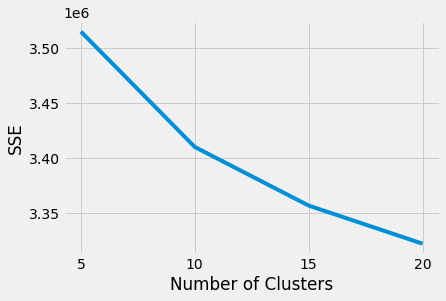

In [77]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 25, 5), sse)
plt.xticks(range(5, 25, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [78]:
kmeans = KMeans(init="random",n_clusters=10,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([5, 5, 6, ..., 8, 0, 4], dtype=int32)

In [79]:
data['cluster_label_cnt_vec'] = kmeans.labels_

In [80]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_cnt_vec
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,5


## Tfidf

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df=5).fit(data.short_description)
len(vect.get_feature_names())

/Users/summerwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


23867

In [105]:
vectorized_word_feature = vect.transform(data.short_description)
vectorized_word_feature

<156859x23867 sparse matrix of type '<class 'numpy.float64'>'
	with 2946585 stored elements in Compressed Sparse Row format>

In [83]:
feature_names = np.array(vect.get_feature_names())

sorted_tfidf_index = vectorized_word_feature.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_tfidf_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['sapphic' 'rewires' 'deft' 'workable' 'syriza' 'permeates' 'huffpollster'
 'monotone' 'crept' 'p5']

Largest tfidf: 
['cool' 'timely' 'damn' 'he' 'goddess' 'vote' 'hmm' 'drip' 'divine' 'mon']


In [84]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 25, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

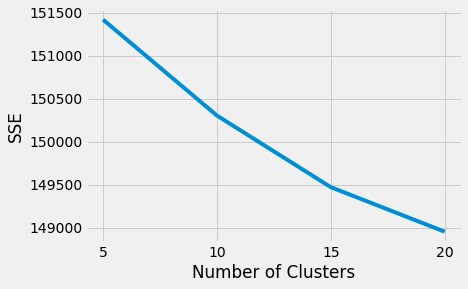

In [85]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 25, 5), sse)
plt.xticks(range(5, 25, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [86]:
kmeans = KMeans(init="random",n_clusters=10,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([3, 4, 9, ..., 5, 9, 5], dtype=int32)

In [87]:
data['cluster_label_tfidf'] = kmeans.labels_

In [88]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_cnt_vec,cluster_label_tfidf
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,5,3


## n-grams

In [89]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(data.short_description)
vectorized_word_feature = vect.transform(data.short_description)
len(vect.get_feature_names())

/Users/summerwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


108550

In [90]:
vectorized_word_feature = vect.transform(data.short_description)
vectorized_word_feature

<156859x108550 sparse matrix of type '<class 'numpy.int64'>'
	with 4889593 stored elements in Compressed Sparse Row format>

In [91]:
feature_names = np.array(vect.get_feature_names())

sorted_ngrams_index = vectorized_word_feature.max(0).toarray()[0].argsort()

print('Smallest tfidf:\n{}\n'.format(feature_names[sorted_ngrams_index[:10]]))
print('Largest tfidf: \n{}'.format(feature_names[sorted_ngrams_index[:-11:-1]]))

Smallest tfidf:
['marry him' 'pine' 'pinch' 'pimp' 'pillows' 'pillow and' 'pillars of'
 'pillars' 'pillar of' 'pillar']

Largest tfidf: 
['the' 'cake' 'black' 'to' 'bodies' 'chocolate' 'and' 'it' 'of' 'you']


In [92]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
    }

# A list holds the SSE values for each k
sse = []
for k in range(5, 25, 5):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(vectorized_word_feature)
    sse.append(kmeans.inertia_)

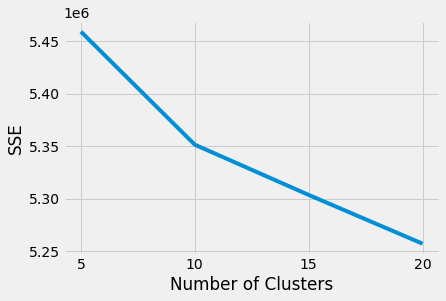

In [93]:
plt.style.use("fivethirtyeight")
plt.plot(range(5, 25, 5), sse)
plt.xticks(range(5, 25, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [94]:
kmeans = KMeans(init="random",n_clusters=10,n_init=10,max_iter=300,random_state=42)
kmeans.fit(vectorized_word_feature)
kmeans.labels_

array([0, 0, 2, ..., 1, 4, 9], dtype=int32)

In [95]:
data['cluster_label_ngrams'] = kmeans.labels_

In [96]:
data.head(1)

,link,headline,category,short_description,authors,date,cluster_label_cnt_vec,cluster_label_tfidf,cluster_label_ngrams
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",23-09-2022,5,3,0


In [97]:
data.cluster_label_cnt_vec.value_counts()

6    56691
8    27472
0    23358
2    12364
5     9347
4     9239
3     8004
1     6207
7     3910
9      267
Name: cluster_label_cnt_vec, dtype: int64

In [98]:
data.cluster_label_tfidf.value_counts()

5    54817
4    34514
1    13823
9    13397
6    10437
8     9147
7     7773
0     6870
3     5471
2      610
Name: cluster_label_tfidf, dtype: int64

In [99]:
data.cluster_label_ngrams.value_counts()

2    55953
1    27347
4    23195
7    13018
9     9358
0     9319
8     8149
5     6318
6     3949
3      253
Name: cluster_label_ngrams, dtype: int64

In [ ]:
#https://realpython.com/k-means-clustering-python/
#https://www.kaggle.com/code/jojushaji/sentimental-analysis-on-amazon-reviews/notebook
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [113]:
# using tfidf
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=500)
dbscan.fit(vectorized_word_feature)

DBSCAN(eps=0.8, min_samples=500)

In [114]:
data['cluster_label_dbscan'] = dbscan.labels_
data.cluster_label_dbscan.value_counts()

-1    156294
 0       565
Name: cluster_label_dbscan, dtype: int64